In [1]:
%matplotlib inline
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageFile
from urllib.request import urlopen
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError

import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

ImageFile.LOAD_TRUNCATED_IMAGES = True


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()


def is_url(url):
    val = URLValidator()
    try:
        val(url)
        return True
    except ValidationError as e:
        return False
    
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


def read_img_url(url):
    with urlopen(url) as file:
        img = Image.open(file)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def read_img_file(f):
    img = Image.open(f)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def read_img(f):
    if is_url(f):
        img = read_img_url(f)
    else:
        img = read_img_file(f)
    
    return img

def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

Using TensorFlow backend.


## Reverse Image Search
- Leverage features of Neural Networks trained on ImageNet.
- Calculate distance using K-Nearest Neighbors (KNN)

<img src='./media/search_example.png'></img>

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

def make_resnet_conv(input_shape):
    '''
    Creates a ResNet50 model trained on ImageNet.
    It includes no final activation function,
    so model returns conv. features.
    
    `input_shape` is a tuple of integers.
    '''
    model = ResNet50(input_shape=input_shape, 
                     weights='imagenet', 
                     include_top=False)
    for layer in model.layers:
        layer.trainable = False   
    
    return model

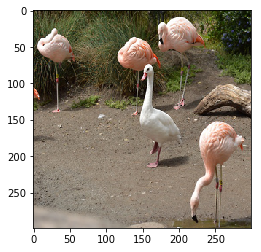

In [3]:
url = 'http://i.imgur.com/P0eRT3y.jpg'
img_width, img_height = 299, 299

img = read_img(url) # reads an image link into a NumPy array...
np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
imshow(np_img);

In [4]:
np_img.shape

(299, 299, 3)

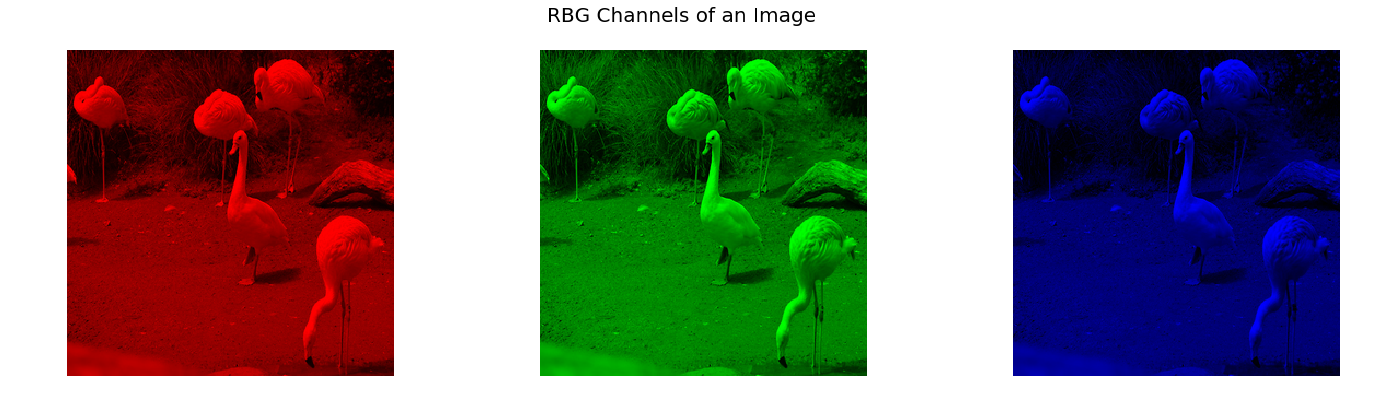

In [5]:
plot_channels(np_img)

In [6]:
np_img = np.expand_dims(np_img, axis=0)
np_img.shape

(1, 299, 299, 3)

In [7]:
model = make_resnet_conv(input_shape=[img_width, img_height, 3])
X = preprocess_input(np_img.astype(np.float))
X_conv = model.predict(X)
delete_model(model)

In [8]:
X[0].shape, X_conv[0].shape

((299, 299, 3), (1, 1, 2048))

We can iron out the extra dimensions

In [9]:
X_conv_2d = X_conv[0].flatten()
X_conv_2d

array([ 0.44383049,  0.15164243,  0.0293529 , ...,  0.03571641,
        0.21206233,  0.        ], dtype=float32)

In [10]:
train_reshape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))

X_conv_2d = X_conv.reshape(train_reshape)
X_conv_2d[0].shape

(2048,)

We can do this in 5 lines of code!

In [11]:
def get_conv_feat(f, model):
    '''
    For any given image (file or url),
    convert to NumPy Array, resize to img_width x img_height,
    preprocess the values for ResNet, get the convolutional features
    from ResNet, and flatten the output.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = process_resnet(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    X_conv_2d = X_conv[0].flatten()
        
    return X_conv_2d

## What did we do with this here code?
- We transform any set of images into 2048 ResNet convoltional features.
- Took 1-2 hours for 100K images using one NVIDIA k80 GPU.

## Why ResNet50?
Let's look at the output of the other popular models:<br>
1. VGG16
2. Xception
3. InceptionV3
4. MobileNet

[Notebook Here](https://nbviewer.jupyter.org/github/yinleon/interpreting_nerual_networks/blob/master/null_features/model_conv_feature_evaluation.ipynb)

Let's use the conv features we calculated for 100k images.

In [13]:
meta_path = '/beegfs/work/smapp/search_feats/google_conv_feats.csv'

X = pd.read_csv(meta_path)
Y = X['filename']

X_conv_2d = X[[_ for _ in X.columns if _ != 'filename']].values.astype(np.float)
X_conv_2d.shape

(38981, 2048)

Training KNN on 100K images w/ 2K features takes about 2 minutes!

In [15]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=20, n_jobs=8, algorithm='ball_tree')
knn.fit(X_conv_2d)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=8, n_neighbors=20, p=2, radius=1.0)

## Serialize it!

In [17]:
from sklearn.externals import joblib

knn_file = '/beegfs/work/smapp/search_feats/knn/google_conv_feats.pkl'
joblib.dump(knn, knn_file)

['/beegfs/work/smapp/search_feats/knn/google_conv_feats.pkl']

In [19]:
def plot_neighbors(neighbors, Y, top=8, per_row=4):
    distance = neighbors[0][0]
    files = Y[neighbors[1][0]].tolist()
    
    for i in range(len(distance[:top])):
        if i % 4 == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = i % 4
        image = read_img(files[i])
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        ax[j].imshow(image)
        ax[j].axis('off')    
        ax[j].annotate(distance[i],
                      (0,0), (0, -32), xycoords='axes fraction', 
                       textcoords='offset points', va='top')

In [26]:
def get_conv_feats(f, model):
    '''
    Converts an image (str of path or url) to a 2d convolutional features AKA logit.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    new_shape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))
    X_conv_2d = X_conv.reshape(new_shape)
    return X_conv_2d

In [21]:
def get_neighbors(f, knn_file, reference_files, top=8):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    
    X_conv_2d = get_conv_feats(f, model)
    neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
    plot_neighbors(neighbors, reference_files, top=top, per_row=4)
    
    delete_model(model)

In [22]:
knn_file = '/beegfs/work/smapp/search_feats/knn/google_conv_feats.pkl'

In [23]:
meta_path = '/beegfs/work/smapp/search_feats/google_conv_feats.csv'
Y = pd.read_csv(meta_path, usecols=['filename'], squeeze=True)

In [28]:
url = 'http://i.imgur.com/P0eRT3y.jpg'

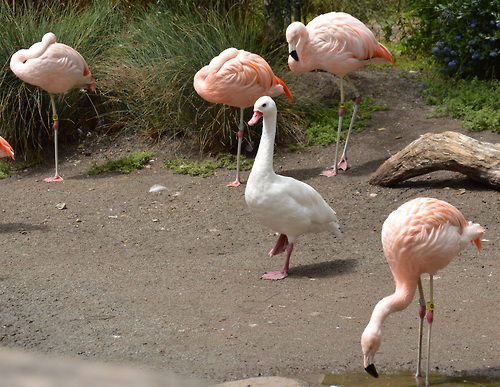

In [29]:
read_img(url)

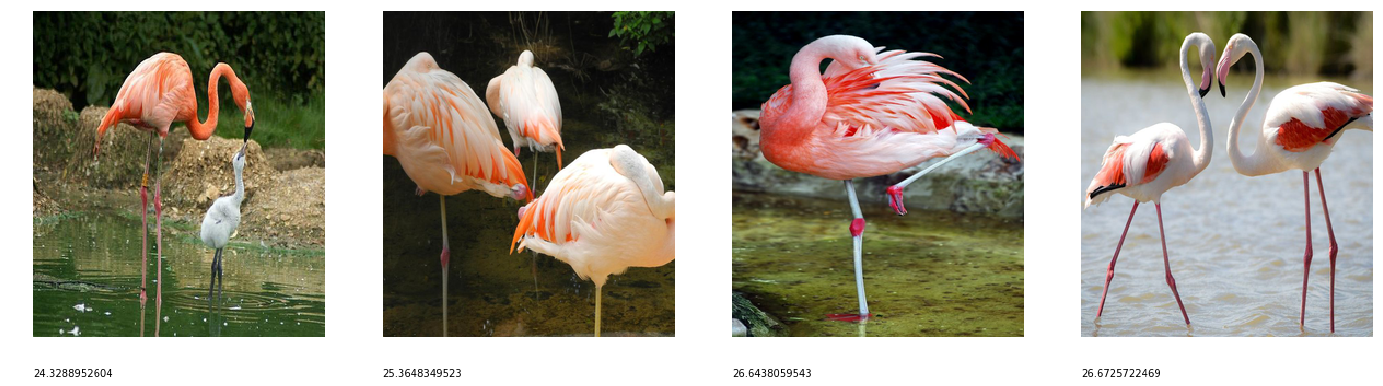

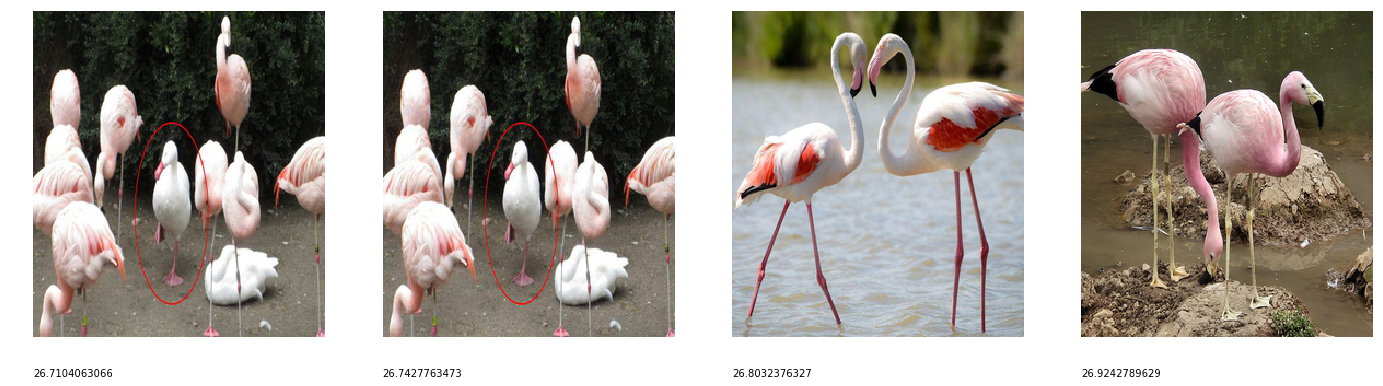

In [30]:
get_neighbors(url, knn_file, Y, top=8)

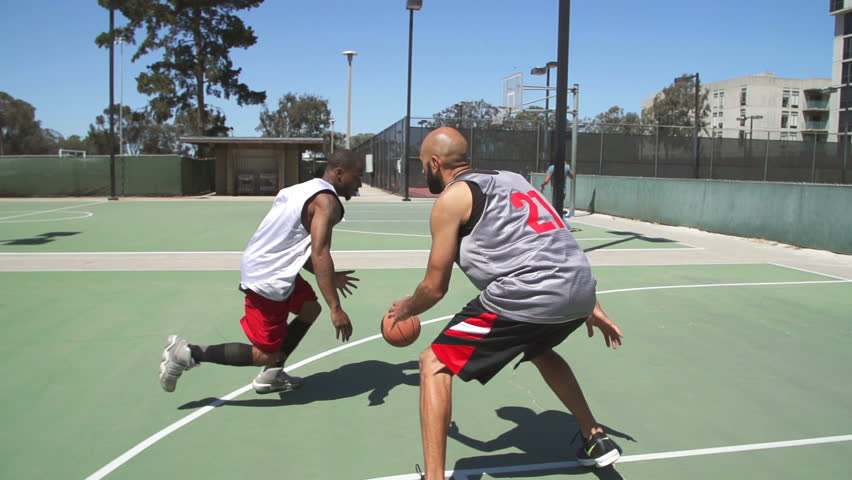

In [31]:
search = 'https://ak5.picdn.net/shutterstock/videos/9646475/thumb/8.jpg?i10c=img.resize(height:160)'
read_img(search)

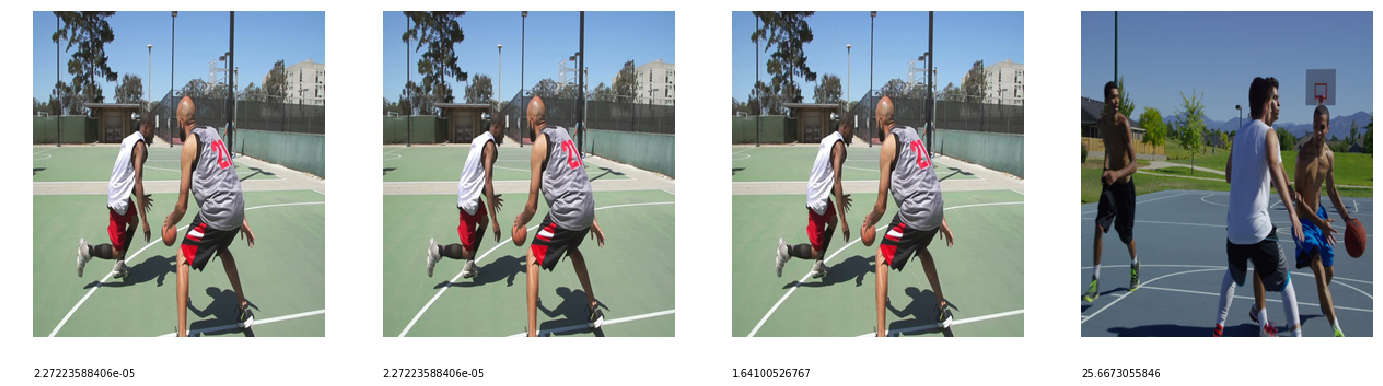

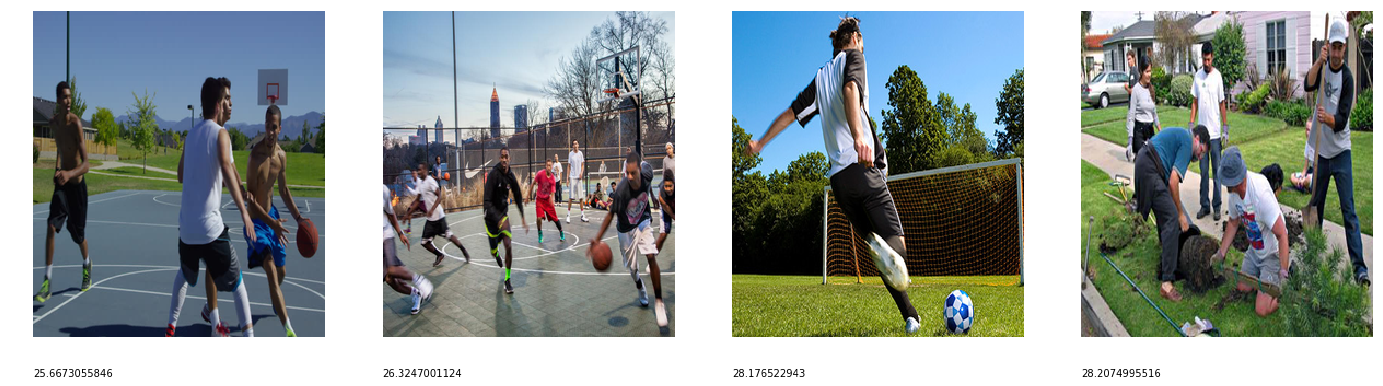

In [32]:
get_neighbors(search, knn_file, Y, top=8)

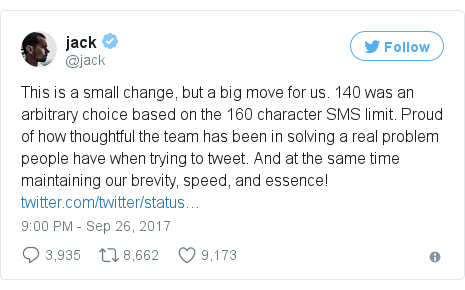

In [36]:
search = 'https://ichef.bbci.co.uk/news/1024/socialembed/https://twitter.com/jack/status/912784057863245824~/news/business-41408798'
read_img(search)

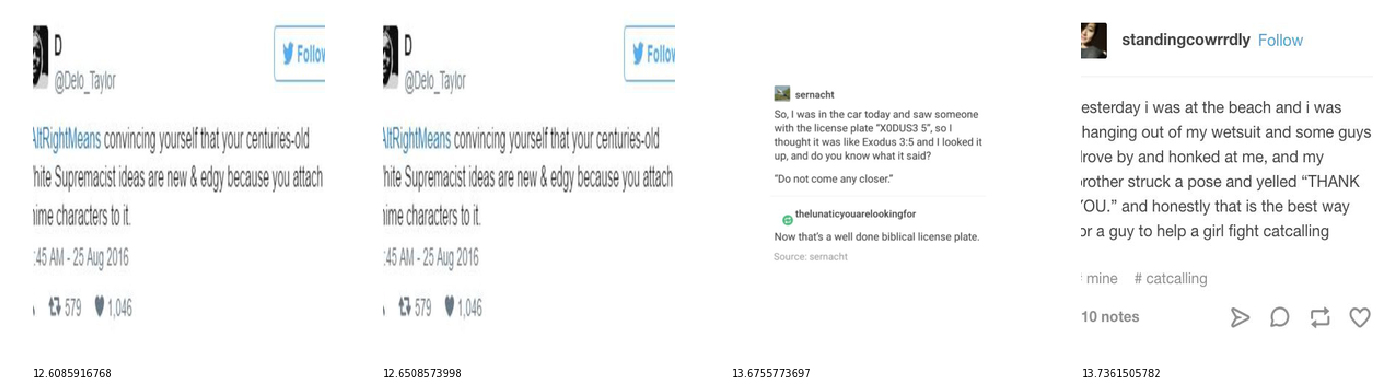

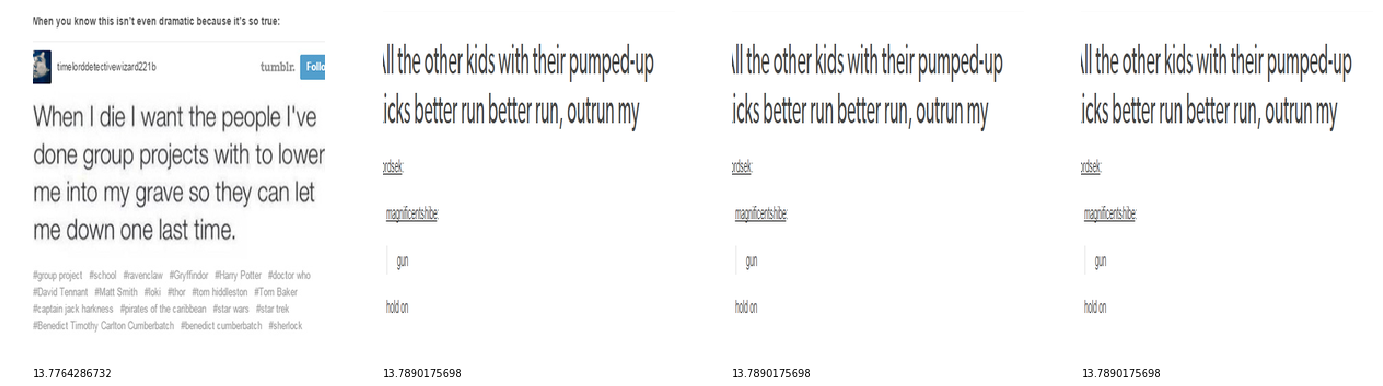

In [37]:
get_neighbors(search, knn_file, Y, top=8)